## Testing the model

### Import Libraries

In [50]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
from joblib import load,dump
import os
from tqdm import tqdm,trange

### Parameters: Part 1

These must match those of the model

In [51]:
patchsize_yx = (128,128)
orientations=8
pixels_per_cell=(16, 16)
cells_per_block=(2, 2)

These can be changed to improve sliding window/non-max suppression

In [52]:
sws_percent = [20,25]
overlap_thresh = 0.5

### Functions for Running The Model


Sliding Window

In [53]:
def sliding_window(image, stepSize, windowSize,returnSize = patchsize_yx):# image is the input, step size is the no.of pixels needed to skip and windowSize is the size of the actual window
    # slide a window across the image
    for y1 in range(0, image.shape[1] - windowSize[1], stepSize):# this line and the line below actually defines the sliding part and loops over the x and y coordinates
        for x1 in range(0, image.shape[0] - windowSize[0], stepSize):
            # yield the current window
            #yield (x, y, image[y: y + windowSize[1], x:x + windowSize[0]])
            y2 = y1 + windowSize[0]
            x2 = x1 + windowSize[1]
            patch = image[y1: y2, x1: x2]
            if patch.shape[0:2] == windowSize:
                return_patch = cv2.resize(patch,returnSize)
                yield (x1, y1,x2, y2, return_patch)

Area funcs for non-max suppression

In [54]:
def area(rect):
    x1,y1,x2,y2 = rect
    return (x2-x1+1)*(y2-y1+1)

def area_intersect(rect1,rect2):
    x1,y1,x2,y2 = rect1
    x3,y3,x4,y4 = rect2
    if x2 < x3:
        return 0
    if x4 < x1:
        return 0
    if y2 < y3:
        return 0
    if y4 < y1:
        return 0
    X1 = max(x1,x3)
    X2 = min(x2,x4)
    Y1 = max(y1,y3)
    Y2 = min(y2,y4)
    return area((X1,Y1,X2,Y2))

def area_union(rect1,rect2):
    return area(rect1) + area(rect2) - area_intersect(rect1,rect2)

def union_to_intersect(rect1,rect2):
    return area_intersect(rect1,rect2)/area_union(rect1,rect2)

The Big Boy for counting Among Us

In [55]:
def how_many_amogus(model,test_img,ret_labeled_img = False ,sws_percent= sws_percent, overlap_thresh= overlap_thresh):
    sws_array = np.array(sws_percent)
    imh,imw,nchannel = test_img.shape
    short_side = min(imh,imw)
    sliding_window_sizes = np.round(sws_array*short_side/100).astype(int)
    step_size = np.ceil(sliding_window_sizes/8).astype(int)


    patches = []
    for i in range(len(sws_percent)):
        tup = (sliding_window_sizes[i],sliding_window_sizes[i])
        patches += list(sliding_window(test_img,step_size[i],tup))

    patches_hog = np.array([hog(patch, orientations=orientations, pixels_per_cell=pixels_per_cell,cells_per_block=cells_per_block, visualize=False, channel_axis=-1)\
        for _,_,_,_,patch in patches])

    labels = model.predict(patches_hog)
    confidence_in_class1 = model.predict_proba(patches_hog)

    labels_confidence = []
    for i,patch in enumerate(patches):
        if labels[i] == 1:
            x1,y1,x2,y2,_ = patch
            labels_confidence.append((confidence_in_class1[i,1],x1,y1,x2,y2))

    labels_confidence.sort(reverse=True)
    true_amogus = []
    for element in labels_confidence:
        conf = element[0]
        rect = element[1:]
        if conf < 0.95:
            break
        not_duplicate = True
        for _,true_rect in true_amogus:

            if union_to_intersect(rect,true_rect) > overlap_thresh:
                not_duplicate = False
                break
        if not_duplicate:
            true_amogus.append((conf,rect))

    if ret_labeled_img:
        image = test_img.copy()
        for conf,rect in true_amogus:
            x1,y1,x2,y2, = rect
            image = cv2.rectangle(image,(x1,y1),(x2,y2),(255,0,0),4)
            
        for conf,rect in true_amogus:
            x1,y1,x2,y2, = rect
            image = cv2.putText(image,str(round(conf,5)),(x1,y1),cv2.FONT_HERSHEY_SIMPLEX,0.6,(0,192,192),2,cv2.LINE_AA)
        return len(true_amogus),image
    else:
        return len(true_amogus)

For evalution

In [56]:
def MAE(y_true,y_pred):
     y_true = np.array(y_true)
     y_pred = np.array(y_pred)
     return np.mean(np.abs(y_true - y_pred))

def RMSE(y_true,y_pred):
     y_true = np.array(y_true)
     y_pred = np.array(y_pred)
     return np.sqrt(np.mean((y_true - y_pred)**2))

### Parameters: Part 2

In [57]:
test_img_dir = "Test_Pic/set4"
answer_file = 'count.txt'
model_path = 'Model/model2.joblib'
numofpic = 600
sample_size = 20

## Main Code

### Load Model and Initialize some to-be-used lists 

In [58]:
model = load(model_path)
result = []

### Loop for image

In [59]:
rand = np.random.randint(numofpic,size = sample_size)

  0%|          | 0/20 [00:00<?, ?it/s]

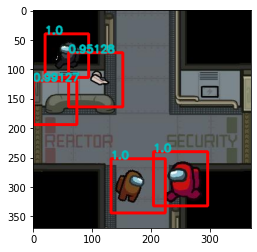

  5%|▌         | 1/20 [00:07<02:31,  7.95s/it]

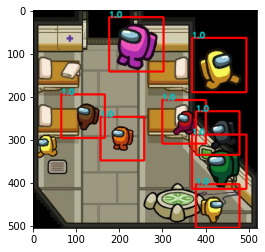

 10%|█         | 2/20 [00:16<02:25,  8.06s/it]

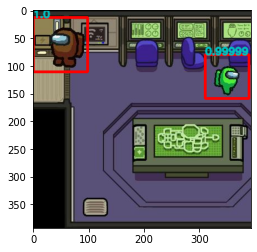

 15%|█▌        | 3/20 [00:23<02:12,  7.80s/it]

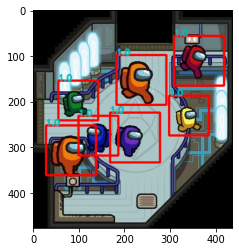

 20%|██        | 4/20 [00:32<02:09,  8.10s/it]

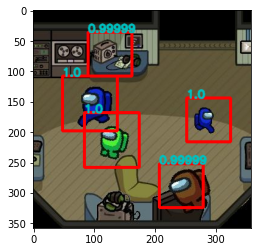

 25%|██▌       | 5/20 [00:39<01:59,  7.94s/it]

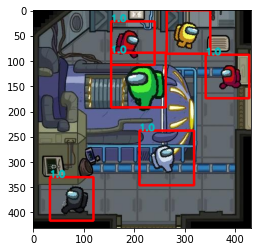

 30%|███       | 6/20 [00:47<01:50,  7.90s/it]

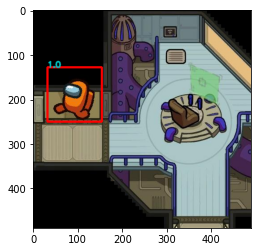

 35%|███▌      | 7/20 [00:55<01:41,  7.77s/it]

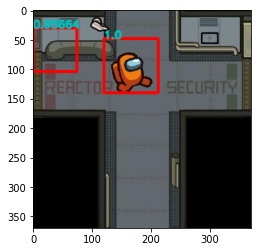

 40%|████      | 8/20 [01:02<01:30,  7.55s/it]

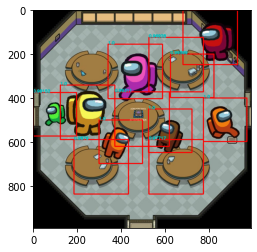

 45%|████▌     | 9/20 [01:10<01:25,  7.77s/it]

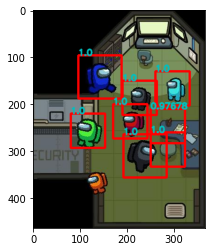

 50%|█████     | 10/20 [01:17<01:16,  7.66s/it]

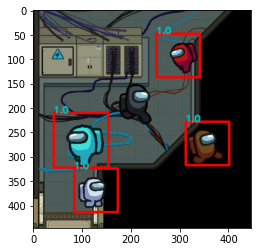

 55%|█████▌    | 11/20 [01:24<01:06,  7.42s/it]

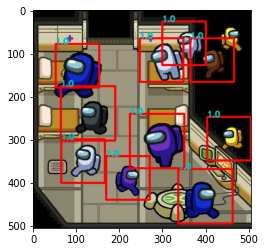

 60%|██████    | 12/20 [01:32<01:00,  7.60s/it]

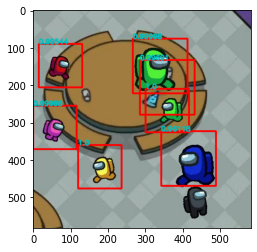

 65%|██████▌   | 13/20 [01:40<00:53,  7.59s/it]

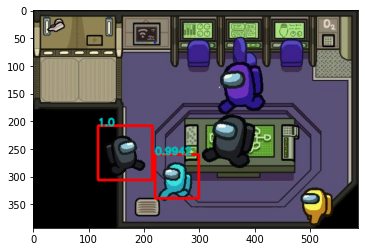

 70%|███████   | 14/20 [01:47<00:44,  7.48s/it]

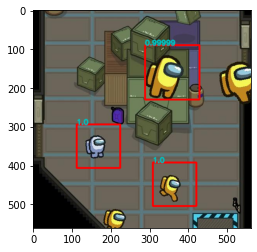

 75%|███████▌  | 15/20 [01:55<00:38,  7.60s/it]

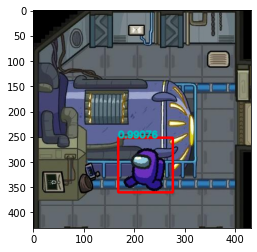

 80%|████████  | 16/20 [02:03<00:30,  7.64s/it]

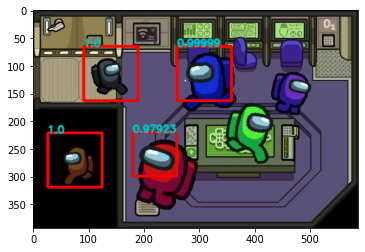

 85%|████████▌ | 17/20 [02:10<00:22,  7.54s/it]

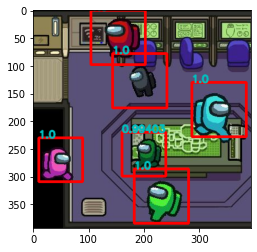

 90%|█████████ | 18/20 [02:17<00:14,  7.42s/it]

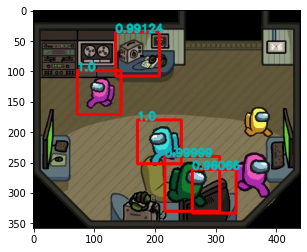

 95%|█████████▌| 19/20 [02:25<00:07,  7.45s/it]

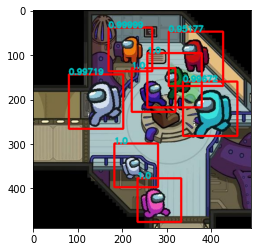

100%|██████████| 20/20 [02:32<00:00,  7.62s/it]


In [60]:

for i in tqdm(rand):

    test_img = cv2.imread(f'{test_img_dir}/img{i}.jpg')
    test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
    x= how_many_amogus(model,test_img)
    result.append(x)
    # x,y = how_many_amogus(model,test_img,ret_labeled_img=True)
    # result.append(x)
    # plt.imshow(y)
    # plt.show()

### Loop for true values

In [61]:
answers = []
with open(f'{test_img_dir}/{answer_file}','r') as file:
    for line in file:
        i, a = line.split()
        answers.append(int(a))

In [62]:
answers = np.array(answers)[rand]


### MAE

In [63]:
result

[5, 8, 2, 7, 5, 6, 1, 2, 12, 8, 4, 10, 7, 2, 3, 1, 4, 6, 5, 8]

In [64]:
print(MAE(result,answers))

1.0


### RMSE

In [65]:
print(RMSE(result,answers))

1.61245154965971


### Accuracy

In [66]:
print(np.mean(result == answers)*100)

45.0
